# Reinforcement learning
### Snake - Monte Carlo
Play games and iteratively improve the state values and corresponding policy

In [2]:
from snake import Game
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation
from IPython.display import HTML, Image

### Setup

In [3]:
# modified dictionary that incorporates random defaults and epsilon greedy
class Policy(dict):
    
    import random
    
    def __init__(self,actions,epsilon=0.1):
        '''
        A policy with built in epsilon greedy and a uniform random choice for non initialized keys 
        actions - list of all possible actions
        epsilon - chance for explore
        '''
        self.actions = actions
        self.eps = epsilon
        super().__init__(self)
        
    def __getitem__(self, key):
        c = random.random()
        if (c<self.eps or key not in self):
            return self.actions[random.randint(0,len(self.actions)-1)]
        else:
            return super().__getitem__(key)

In [4]:
# game parameters
grid = 8
s_size = 3
# start game
game = Game(grid, s_size)
game.reset()

# discount factor
g = 0.9

# initialize policy
policy = Policy([0,1,2,3])

# dummy state for a lost game
LOSS = tuple(np.ones(6)*-1)

### Learning

In [5]:
# aggregated values for states and actions
agg = {}
# calculated Q values
Q = {}

# run MC loop
for i in range(10000):
    # play one episode
    # game log
    history = []
    r = 0
    score = 0
    turns = 0
    while (True):
        # count turns (success in terms of not dying)
        turns+=1
        # count score
        if (game.score>score):
            score = game.score
        # get current state
        s = tuple(game.get_state())
        # choose action
        a = policy[s]
        # update history before moving to the next state
        history.append((s,r,a))
        # apply action
        game.snake.d = a
        # run one game step, get reward and check if episode is finished
        r,e = game.iterate() 
        if (e==-1):
            # game is lost, add final dummy state
            history.append((LOSS,r,0))
            # start a new episode
            break
        if (e==1):
            # eat apple, add modified state
            eat = np.array(s)
            eat[-2:] = 0
            history.append((tuple(eat),r,0))
            r = 0
    # update Q returns (values for this episode)
    q_values = []
    value = 0
    for s,r,a in reversed(history):
        q_values.append((s,a,value))
        # update value
        value = r + g*value
    q_values.reverse()
    # update aggregated q_values
    for s,a,v in q_values:
        # aggregated values
        if ((s,a) in agg):
            agg[(s,a)].append(v)
        else:
            agg[(s,a)] = [v]
        # average
        if (s in Q):
            Q[s][a] = np.mean(agg[(s,a)])
        else:
            Q[s] = {}
            Q[s][a] = np.mean(agg[(s,a)])
    # update policy
    for s in Q:
        aq = ([i for i in Q[s].items()])
        a = np.argmax([i[1] for i in aq])
        policy[s] = [i[0] for i in aq][a]
    # print progress
    if (i%1000==0):
        print(i,turns,score)

0 3 0
1000 10 1
2000 2 0
3000 11 1
4000 10 1
5000 3 0
6000 15 2
7000 39 6
8000 74 8
9000 54 7


### Animation

In [6]:
# extract the policy without epsilon greedy
p = dict(policy)

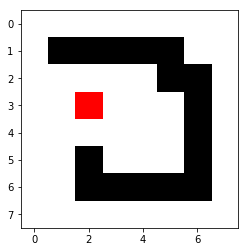

In [7]:
# render a game animation
fig, ax = plt.subplots()
image = ax.imshow(game.board)

g = Game(grid, s_size)
g.reset()

def init():
    image.set_data(g.board)
    return (image,)

def animate(i):
    s = g.get_state()
    a = p[tuple(s)]
    g.snake.d = a
    g.iterate() 
    g.draw()
    image.set_data(g.board)
    return (image,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=300, interval=120, 
                               blit=True)

anim.save('./animations/monte_carlo.gif', writer='imagemagick', fps=30)

### Result

In [8]:
Image(url='./animations/monte_carlo.gif')